# Data-driven approach to identify Sheath/Socket specific markers

This notebook provides a guide for our aproach in identifying Sheath/Socket glial specific genes as described in our manuscript.

The following packages need to be installed before running this notebook:

1. `scanpy`: https://scanpy.readthedocs.io/en/stable/installation.html
2. `sklearn`: https://scikit-learn.org/stable/install.html
3. `tqdm`: https://github.com/tqdm/tqdm#installation
4. `plotly`: https://plotly.com/python/getting-started/

Refer to the our github page for environment setup: https://github.com/settylab/worm-glia-atlas

# Parameters

`Anndata` objects are the primary input for this notebook. The data (count matrix) within `anndata` object should be normalized, logtransformed. Additionally, imputed gene expression is used for the feature ranking/identification step. The following parameters that need to be specified are denoted below:
1. `CLASS_LABELS`   : is the `anndata.obs` field that contains the ground truth labels for which to identify markers for.
2. `CLUSTER_LABELS` : is the `anndata.obs` field that contains the leiden clusters that either belong to either two of the classes in the ground truth labels.
3. `USE_GENES`      : is the `anndata.var` field that determines whether a gene is to be included in the analysis, this is a column of boolean values and by default is set to the `highly_variable` genes.
3. `USE_LAYER`      : is the `anndata.layer` field that contains the imputed count matrix data.
5. `SAVE_PATH`      : a folder/path to save trained models and anndata outputs.
6. `EXCLUDE_GROUPS` : are clusters to exclude from the analysis.
7. `IGNORE_FEATURES`: are the genes to be excluded during the ranking portion of the anlaysis.


The code cell below shows the input of this analysis.

In [1]:
# anndata.obs columns labels used in analysis
CLASS_LABELS = 'SheathSocket_label'
CLUSTER_LABELS = 'Cluster_Celltype'

# anndata.var columns label
USE_GENES = 'highly_variable'

# anndata.layers keys
USE_LAYER = 'magic_imputed_postBC'

# save path
SAVE_PATH = 'SheathSocket_Analysis'

# other arguments
EXCLUDED_GROUPS = ['30 - Unvalidated', '17 - Unvalidated', '18 - Unvalidated',
                   '29 - Unvalidated', '20 - PChL/R', '13 - Seam cells', '14 - Posterior hyp']       # cells/clusters we ignored as described in the manuscript
IGNORE_FEATURES = ['nlp-77','msa-1','brp-1']                                                         # features we ignored as described in the manuscript
N_FEATURES = 10

# Imports

In [2]:
# important imports
import anndata as AnnData
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# distance metrics related imports
import scipy
from scipy.stats import spearmanr
from scipy.stats import zscore
from scipy.stats import pearsonr
from sklearn.metrics import pairwise_distances

# for t-test to determine if 
from scipy.stats import ttest_ind


# utils
import tqdm
import os 
import glob
import sys

# multiprocessing/parallelizing tasks
from joblib import Parallel, delayed, dump, load

# imports needed for marker selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_precision_recall_curve, plot_confusion_matrix, average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics.pairwise import paired_distances
from sklearn.feature_selection import RFE

# copy models
from copy import deepcopy

# Plot Presets

In [3]:
%matplotlib inline

# set matplotlib style -- ggplot
style.use('ggplot')

# config for matplotlib
matplotlib.rcParams['figure.figsize'] = [5,5]
matplotlib.rcParams['figure.dpi'] = 2000
matplotlib.rcParams['image.cmap'] = 'Spectral_r'

# config for scanpy
sc.settings.verbosity = 0
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')


# no bounding boxes or axis:
matplotlib.rcParams['axes.spines.bottom'] = "off"
matplotlib.rcParams['axes.spines.top'] = "off"
matplotlib.rcParams['axes.spines.left'] = "off"
matplotlib.rcParams['axes.spines.right'] = "off"

scanpy==1.9.1 anndata==0.8.0 umap==0.5.1 numpy==1.21.0 scipy==1.7.0 pandas==1.3.0 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4


In [4]:
# functions for feature ranking 
sys.path.append('../utils/')
from feature_ranking import *

# The AnnData Object

For this analysis, we use our identified sheath and socket glial labels identfied by hierarchical clusterings described in our manusctipt and 
rank features/genes that are highly correlated with these labels 

The anndata can be downloaded from the URL below. Replace the path in `line 2` with your anndata object

In [5]:
# load in the data
ad_url = "https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/worm-glia-atlas/GliaOnly.h5ad"
adata = sc.read("data/GliaOnly.h5ad", backup_url=ad_url)
adata

AnnData object with n_obs × n_vars = 20810 × 12376
    obs: 'Celltype', 'sex_specificity', 'leiden_postBC', 'sex', 'SheathSocket_label', 'Compartments', 'leiden_preBC', 'cluster_sex_label', 'Cluster_Celltype'
    var: 'highly_variable', 'previous_highly_variable', 'transcription_factors', 'transporters'
    uns: 'BatchCorrected_LeidenClusters_colors', 'Compartments_colors', 'Identified_SheathSocket_Markers', 'SheathSocket_label_colors', 'Validations_colors', 'cluster_sex_label_colors', 'dendrogram_Cluster_Celltype', 'gene_validations', 'leiden_noBC_colors', 'leiden_postBC_colors', 'sex_colors', 'sex_frac_Glia_postBC', 'sex_specificity_colors'
    obsm: 'DM_EigenVectors_postBC', 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_noBC'
    varm: 'cluster_means', 'pairwise_cluster_count'
    layers: 'magic_imputed_postBC'

In [6]:
# set the cluster colors to be used
adata.uns['Custom_Cluster_Colors'] = {'0 - PHso2': '#ffff00',
 '1 - IL/OLsh': '#1ce6ff',
 '10 - AMsh/PHsh': '#63ffac',
 '11 - ILso': '#b79762',
 '12 - OLso': '#004d43',
 '13 - Seam cells': '#8fb0ff',
 '14 - Posterior hyp': '#997d87',
 '15 - PDEsh': '#5a0007',
 '16 - CEPsh': '#809693',
 '17 - Unvalidated': '#6a3a4c',
 '18 - Unvalidated': '#1b4400',
 '19 - CEPso': '#4fc601',
 '2 - ADEso & PDEso': '#ff34ff',
 '20 - PChL/R': '#3b5dff',
 '21 - HOsh & HOso': '#4a3b53',
 '22 - PCso': '#ff2f80',
 '23 - IL/OLsh': '#61615a',
 '24 - SPso': '#ba0900',
 '25 - PCsh': '#6b7900',
 '26 - ADEsh': '#00c2a0',
 '27 - PHsh': '#ffaa92',
 '28 - ILso': '#ff90c9',
 '29 - Unvalidated': '#b903aa',
 '3 - IL/OLsh': '#ff4a46',
 '30 - Unvalidated': '#d16100',
 '31 - SPsh': '#ddefff',
 '4 - PHso1 + AMso': '#008941',
 '5 - IL/OLsh': '#006fa6',
 '6 - ILsh': '#a30059',
 '7 - ILso': '#ffdbe5',
 '8 - OLso': '#7a4900',
 '9 - OLso': '#0000a6'}

The `anndata` object contains several meta data information as shown by the output from the previous cell. We visualize `CLASS_LABELS` & `CLUSTER_LABELS` below which are the primary we `anndata.obs` field we focus on in this tutorial

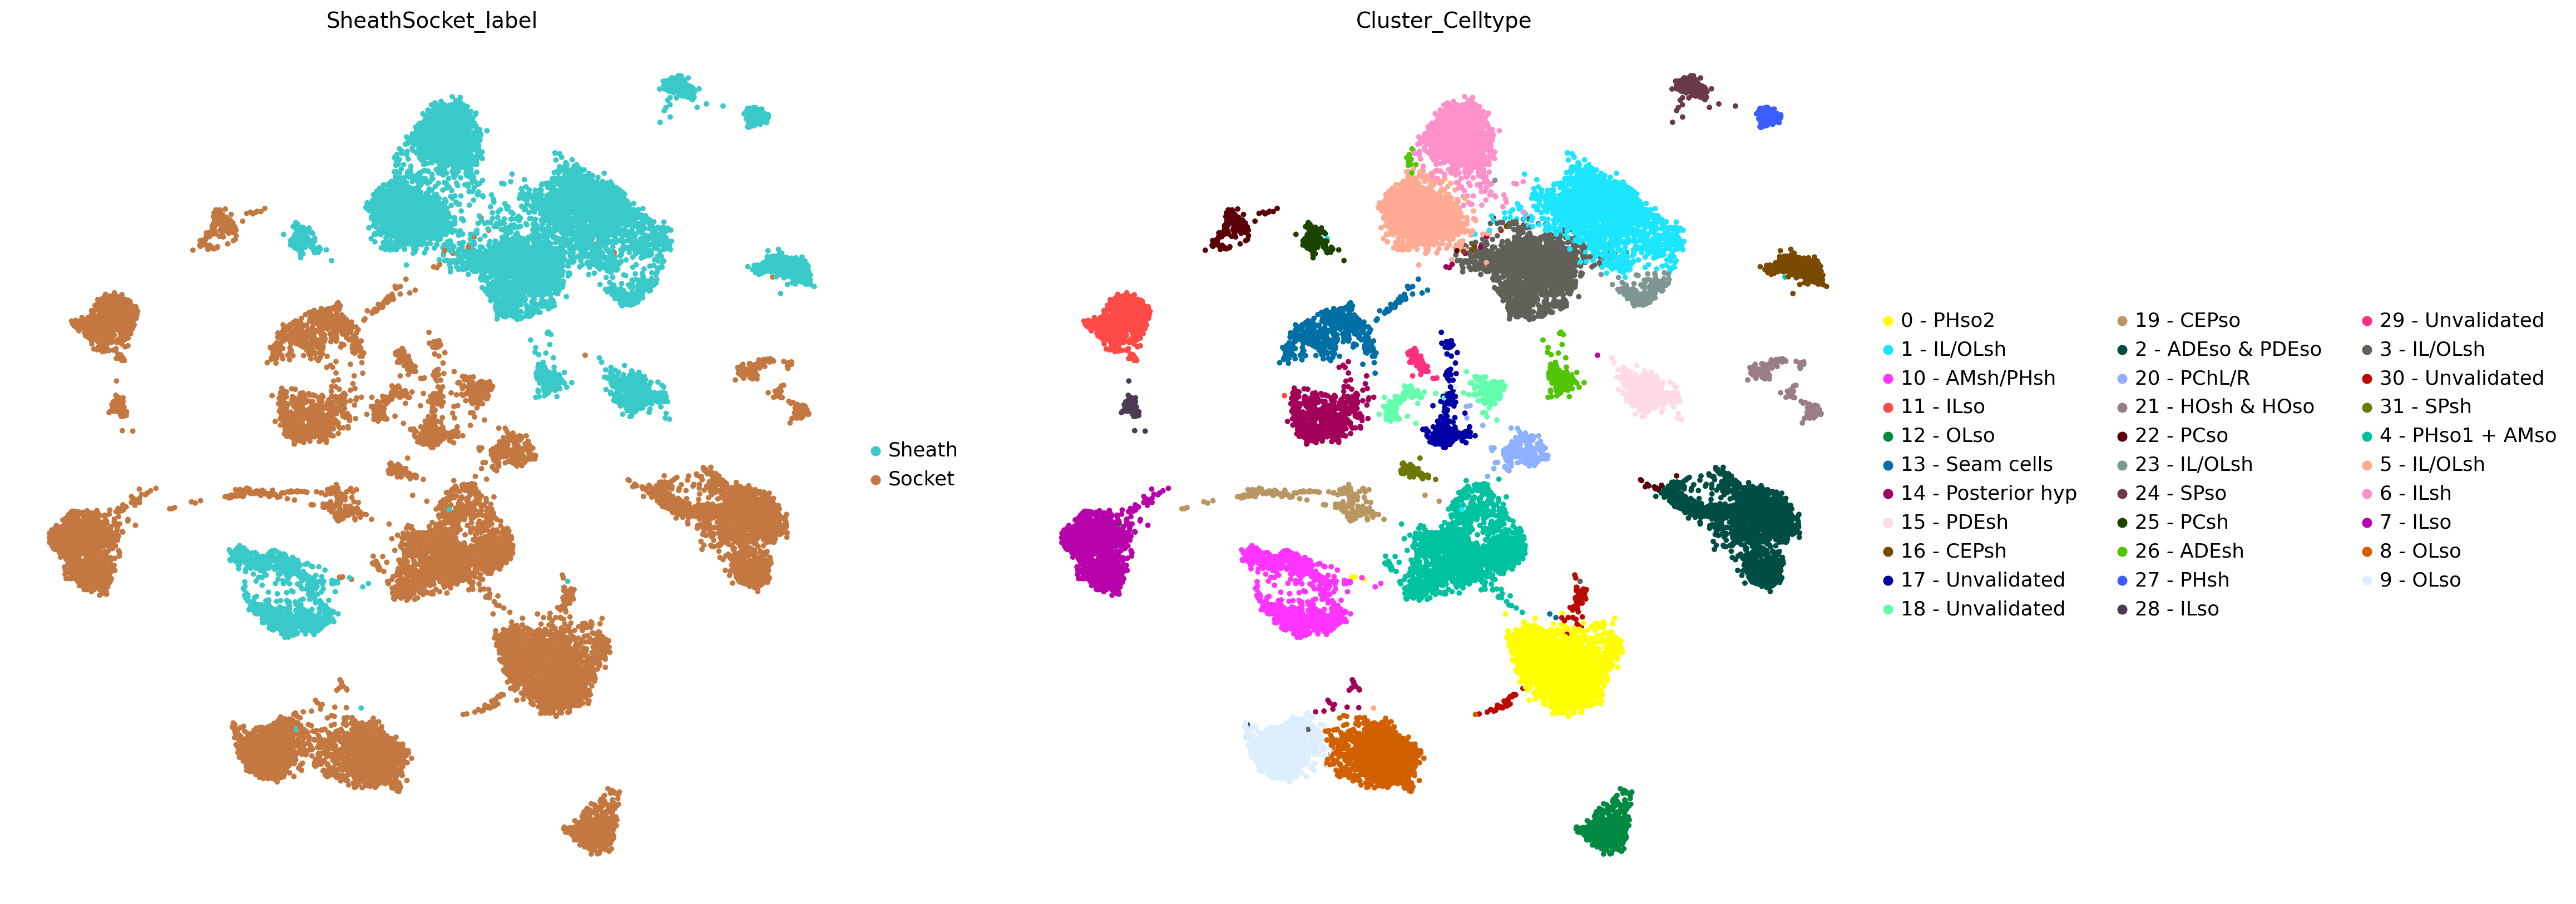

In [7]:
with matplotlib.pyplot.rc_context({'figure.figsize':(10,10)}):
    sc.pl.umap(
        adata,
        color=[CLASS_LABELS, CLUSTER_LABELS],
        frameon=False,
        size=50
    )

# Filter Features/Genes

We first perform pre-filtering of the genes. For our feature ranking, we constrain our selection of genes to only identified highly variable genes which is is denoted by `anndata.var[USE_GENES]`. 

We filter genes by calculating the fraction of cells expressing a gene within each cluster in `anndata.obs[CLUSTER_LABELS]`.

Genes are kept if they are expressed (have non-zero counts) in greater than <b><i>45% (0.45) of cells in a specific cluster AND if this is the case for more than one cluster or more</i></b>. 

This filtering step can be done by calling `filter_features()`. This function modifies the `anndata` in place and the following are added:
1. `anndata.obs['exclude_cells']` : a column in `anndata.obs` attribute containing boolean values indicating whether a cell is to be included/excluded
2. `anndata.var['identified_genes']` : a columns in `anndata.var` attribute containing boolean values indicating which genes are to be the focus of the analysis

In [8]:
filter_features(adata, use_feature_set=USE_GENES, 
                cluster_label=CLUSTER_LABELS, ignore_clusters=EXCLUDED_GROUPS)

Identifying genes: 100%|████████████████████| 3626/3626 [02:02<00:00, 29.60it/s]

Number of genes identified: 286


# Create Data

Before proceeding further, we subset the dataset to obtain <b>male only cells</b> as mentioned in our manuscript. The following
code cell shows this process:

In [9]:
# male only data -- will be used for this analysis
adata_male = adata[
    (adata.obs['sex'] == 'Male') & 
    (adata.obs['sex_specificity'].isin(['Both','Male'])),:].copy()
adata_male

AnnData object with n_obs × n_vars = 9077 × 12376
    obs: 'Celltype', 'sex_specificity', 'leiden_postBC', 'sex', 'SheathSocket_label', 'Compartments', 'leiden_preBC', 'cluster_sex_label', 'Cluster_Celltype', 'exclude_cells'
    var: 'highly_variable', 'previous_highly_variable', 'transcription_factors', 'transporters', 'identified_genes'
    uns: 'BatchCorrected_LeidenClusters_colors', 'Compartments_colors', 'Identified_SheathSocket_Markers', 'SheathSocket_label_colors', 'Validations_colors', 'cluster_sex_label_colors', 'dendrogram_Cluster_Celltype', 'gene_validations', 'leiden_noBC_colors', 'leiden_postBC_colors', 'sex_colors', 'sex_frac_Glia_postBC', 'sex_specificity_colors', 'Custom_Cluster_Colors', 'Cluster_Celltype_colors'
    obsm: 'DM_EigenVectors_postBC', 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_noBC'
    varm: 'cluster_means', 'pairwise_cluster_count'
    layers: 'magic_imputed_postBC'

# Create Training, Validation & Test Set

`split_data()` splits the cells within the `anndata` object into training/validation/test (70/20/10%) dataset accordingly for each of the clusters in `anndata.obs[CLUSTER_LABELS]` to ensure proper representation during model training.

This function also modifies the `anndata` in place and adds the following:

1.`anndata.obs['data_splits']`: a new column in the `anndata.obs` attribute containing either training/validation/test labels for each cell

In [10]:
split_data(ad_data=adata_male, cluster_label=CLUSTER_LABELS) 

Splitting Data: 100%|██████████████████████████| 31/31 [00:00<00:00, 985.71it/s]


We can view the training/validation/test splits below by plotting the umap and coloring it by `data_splits` which has been added:

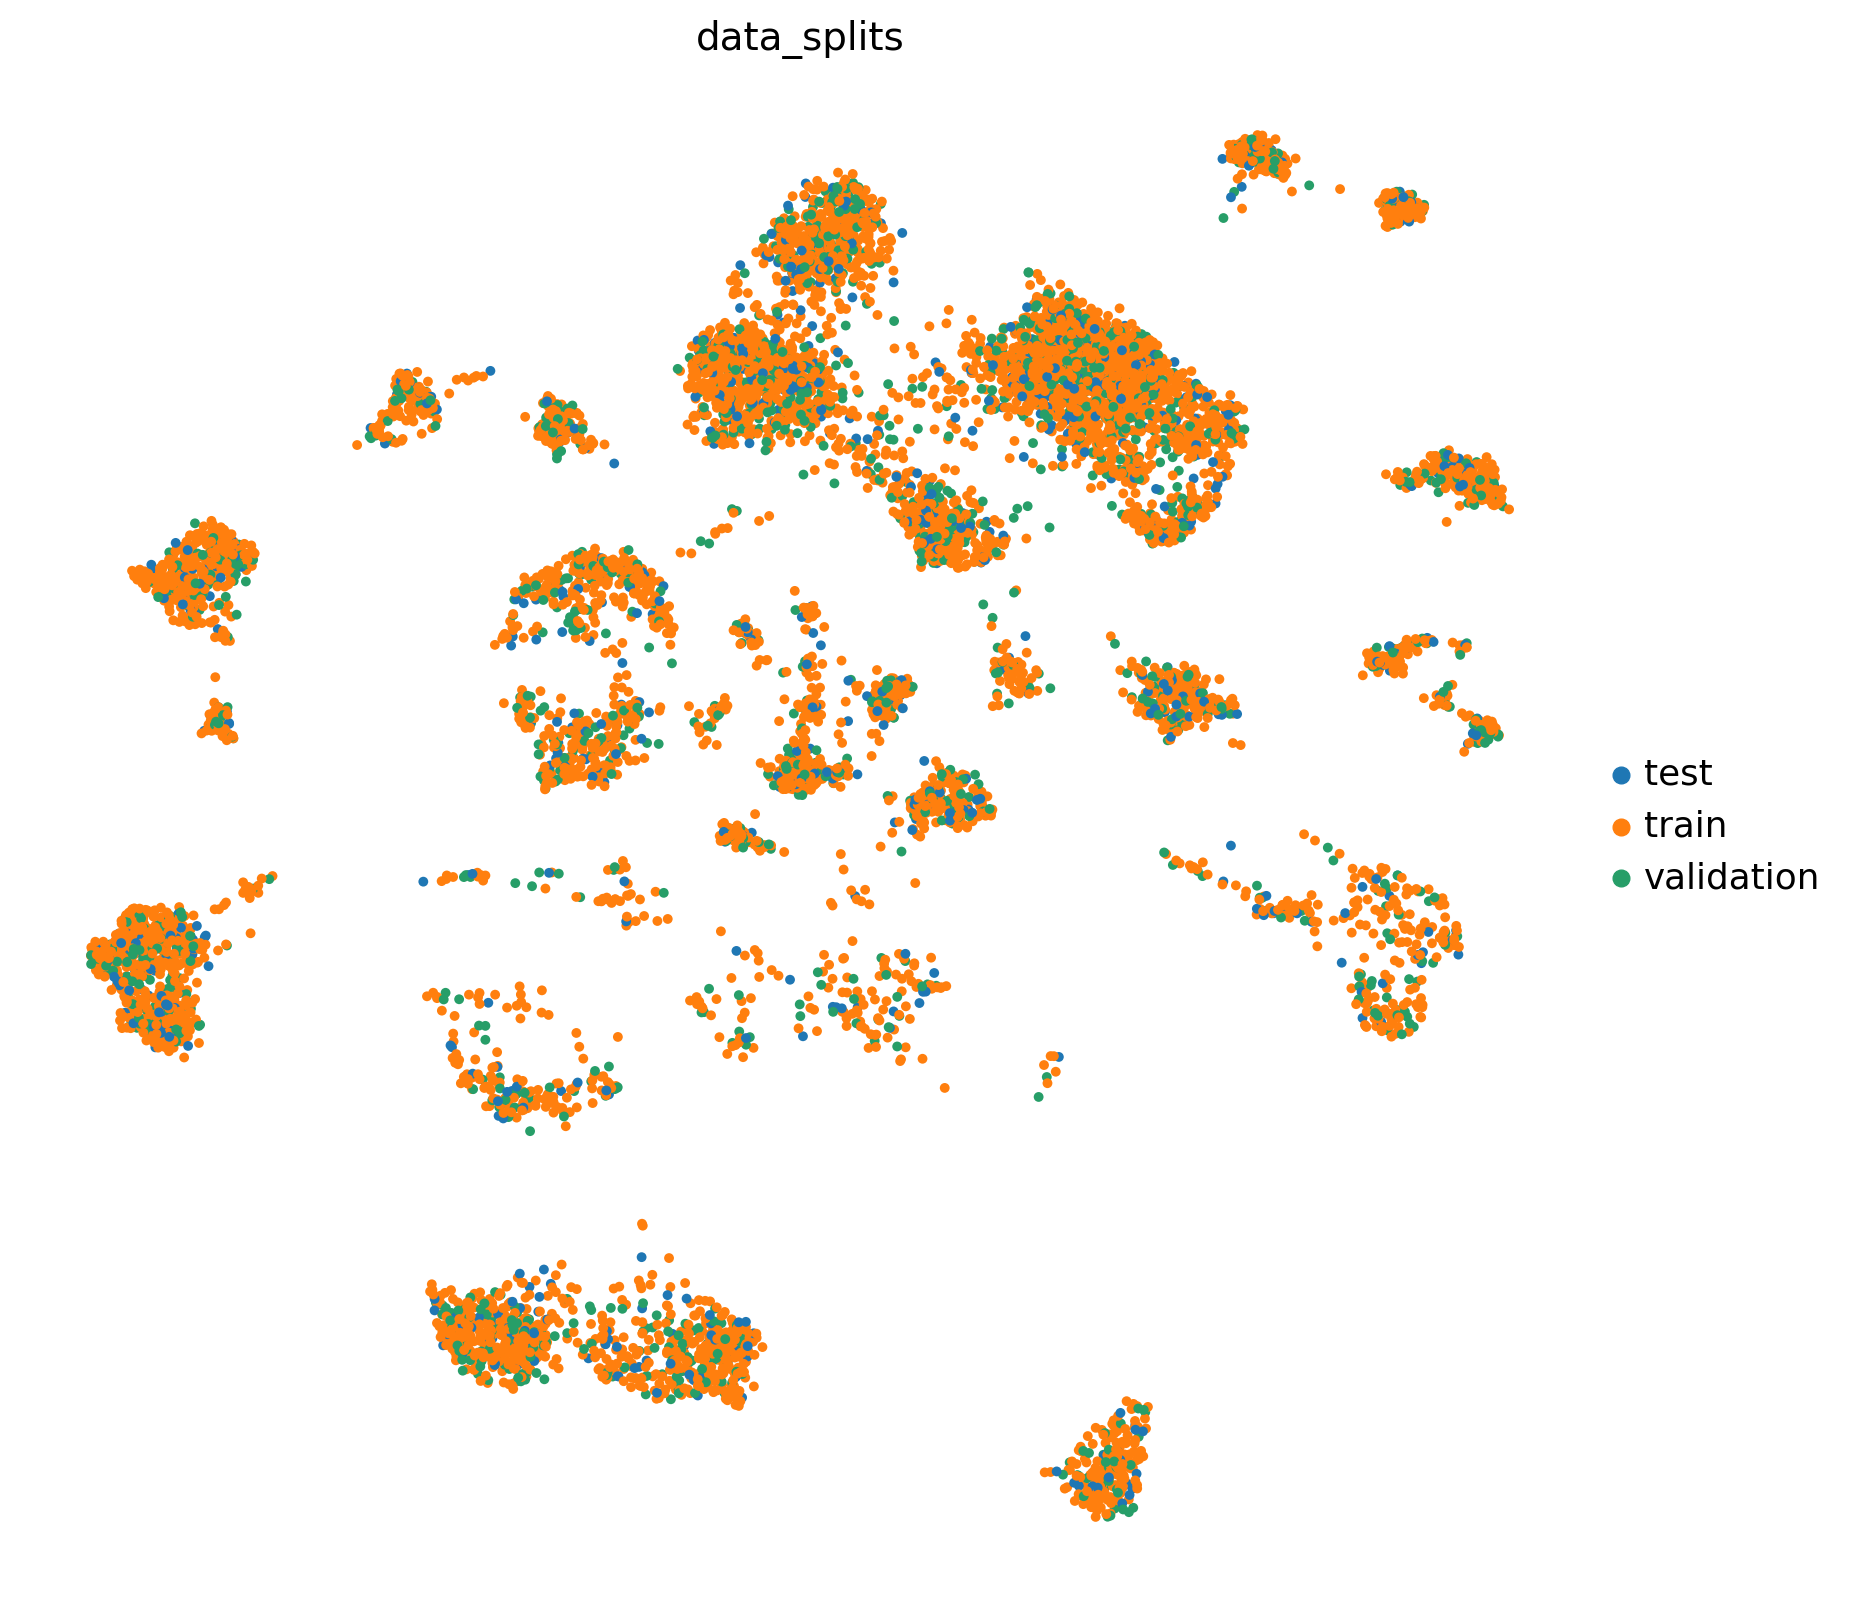

In [11]:
# probably visualize the umap with the labeled test-validation-test splits
with matplotlib.pyplot.rc_context({'figure.figsize':(10,10)}):
    sc.pl.umap(
        adata_male,
        color=['data_splits'],
        frameon=False,
        size=50
    )

# Model Training & Selection

As described in our manuscript, we learn a mapping between the feature matrix and the target vector by leveraging a binary classifier using the scikit-learn package and create a `Logistic Regression` model to dishtinguish between the two classes in `anndata.obs[CLASS_LABELS]`.

A feature matrix and target vector pair was constructed for each of the labels in `anndata.obs['data_splits']` where the entry of the feature matrix is the imputed gene expression avalues of the genes identified in `anndata.var['identified_genes']`. 

Multiple models are trained using `L1/lasso-regularization` under different regularization conditions: `[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]` 

This can be done by calling `train_model()` which returns a selected regularized model based on highest mean-accuracy metrics on the validation dataset and also adds mean-accuracy scores for each of the trained models in `anndata.uns['model_selection_metrics']`.

In [12]:
# return_all params -- will return things other than the model such as the score
model, trained_models, scores = train_model(ad_data=adata_male, class_label=CLASS_LABELS, 
                               use_layer=USE_LAYER, save_path=SAVE_PATH, return_all=True)

Training Model(s): 100%|██████████████████████████| 8/8 [00:00<00:00, 10.74it/s]


best_model: model_0.05
7 out of 286 features remain in the selected model.
Directory 'SheathSocket_Analysis' already exists -- saving results to SheathSocket_Analysis.


In [13]:
# checkout the scores for each of the models
scores

train_score  validation_score  test_score
model_0.001     0.938137          0.936835    0.932741
model_0.005     0.994815          0.995742    0.997462
model_0.01      0.995173          0.995742    0.997462
model_0.05      0.996782          0.997871    0.998731
model_0.1       0.996960          0.997161    0.998731
model_0.5       0.997497          0.997161    0.998731
model_1.0       0.998212          0.997161    0.998731
model_5.0       0.999106          0.997871    0.998731

We select the least regularized model, which has comparable mean accuracy results in the validation dataset as the automatically selected model (`model_0.05`) as described in our manuscript.

In [14]:
model = trained_models['model_5.0']

# Feature Ranking/Selection

To select markers, we specify the target class we want to identify for (`Sheath` or `Socket` which are the two classes available in `anndata.obs[CLASS_LABELS]`). By default <i>some genes</i> have been excluded from this selection process, genes we have identified a priori that seem to be expressed broadly. Additionally, as described in the manuscript, we select a default of `n_features=5 genes`.

We identify markers as described in the manuscript which can be done by calling `rank_genes()`. This function modifies the anndata in place and adds the results on to the `anndata` object within `anndata.uns['<target_class>_marker_results']`. Which contains dictionaries of the results.

Particularly `anndata.uns['<target_class>_marker_results']['top_<n_features>']` contains the top `n_features` selected genes

## Marker Identification -- Socket Glia

In [15]:
rank_genes(ad_data=adata_male, model=model, target_class='Socket', 
                 class_labels=CLASS_LABELS, cluster_labels=CLUSTER_LABELS, use_layer=USE_LAYER, n_features=N_FEATURES, ignore_features=IGNORE_FEATURES)

Number of features to select: 10 from the available 29 features in the current model. ignoring: ['nlp-77', 'msa-1', 'brp-1']


## Marker Identification -- Sheath Glia

In [16]:
rank_genes(ad_data=adata_male, model=model,target_class='Sheath', 
                 class_labels=CLASS_LABELS, cluster_labels=CLUSTER_LABELS, use_layer=USE_LAYER, n_features=N_FEATURES, ignore_features=IGNORE_FEATURES)

Number of features to select: 10 from the available 29 features in the current model. ignoring: ['nlp-77', 'msa-1', 'brp-1']


# Visualize Results

The markers can be accessed as follows in the current `anndata` <b>adata_male</b> object.

In [17]:
# the top 10 features/genes identified by the anlayses can be accessed as follows
identified_markers = {
    'Socket':adata_male.uns['Socket_marker_results'][f'top_{N_FEATURES}'],
    'Sheath':adata_male.uns['Sheath_marker_results'][f'top_{N_FEATURES}']
}

markers = identified_markers['Sheath'] + identified_markers['Socket']

### Gene Expression -- Whole Data

We can visualize the results as follows using the `scanpy` module on both the Hermaphrodite and Male data.

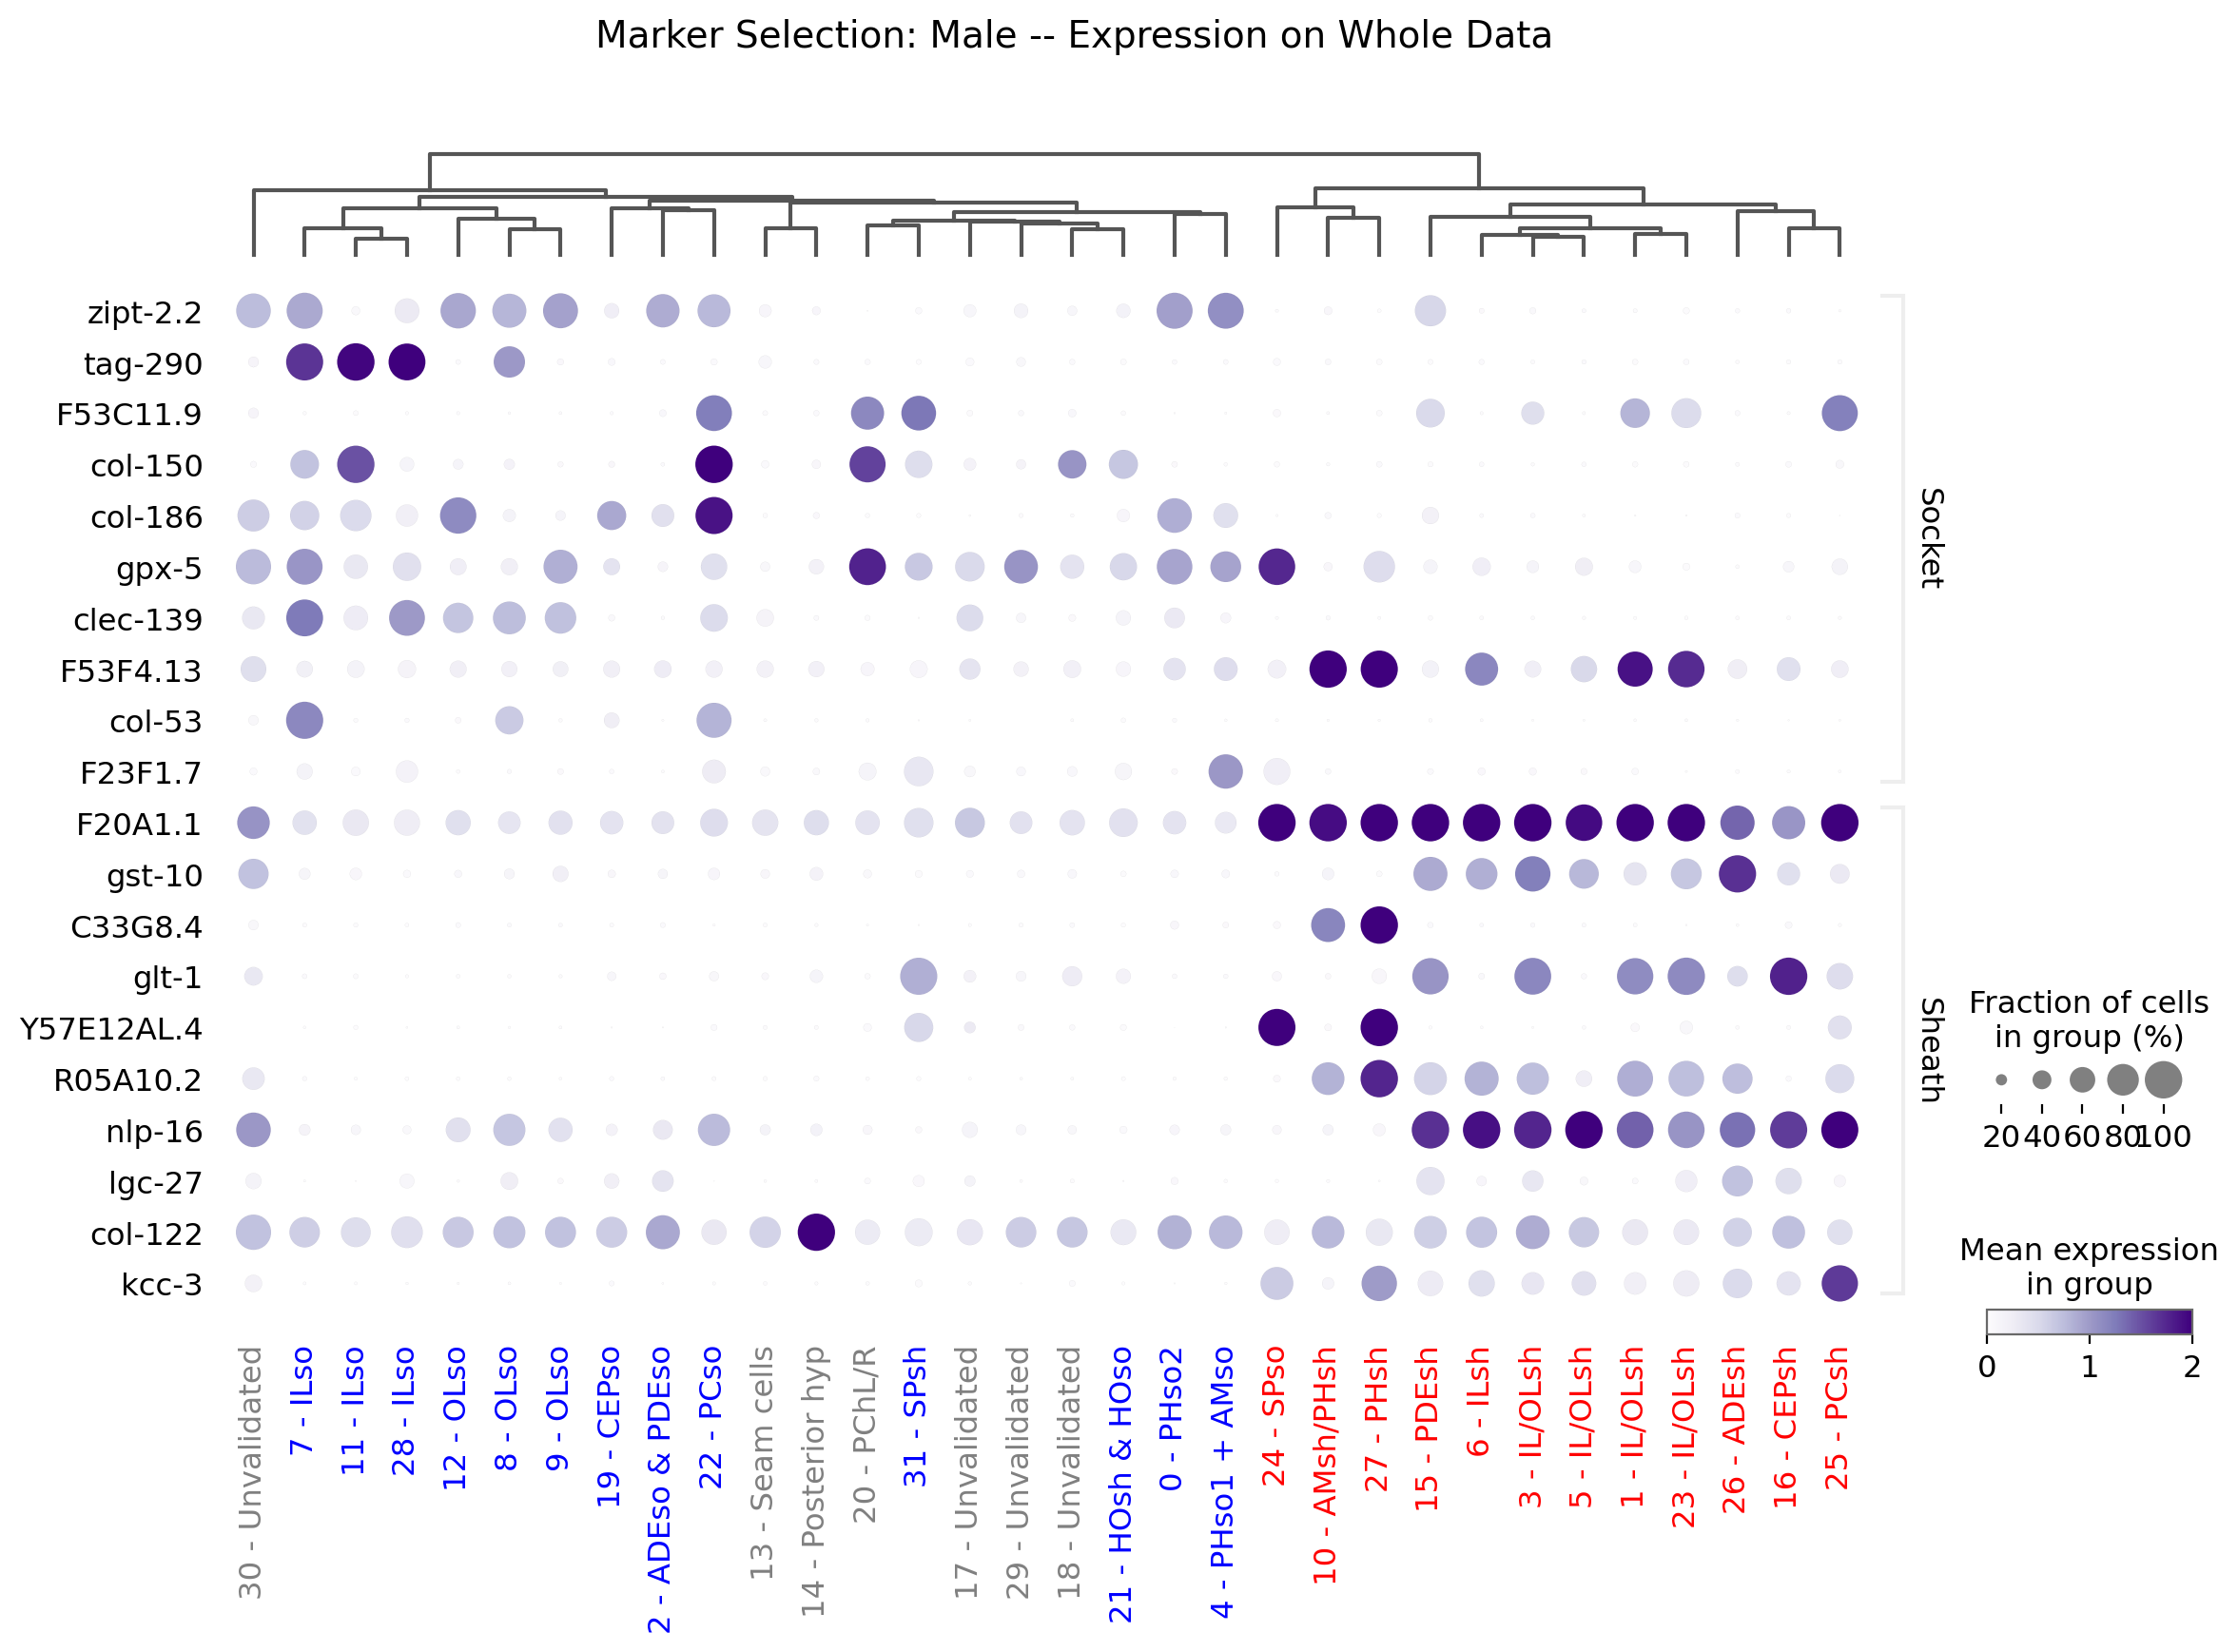

In [18]:
# Identify the sheath and socket clusters -- these clusters are labeled for ease of visualization, excluded clusters from the analysis are
# also highlighted in gray
socket_clust = adata.obs.loc[(adata.obs['SheathSocket_label'] == 'Socket') & (~adata.obs['Cluster_Celltype'].isin(EXCLUDED_GROUPS)),'Cluster_Celltype'].unique().tolist()
sheath_clust = adata.obs.loc[(adata.obs['SheathSocket_label'] == 'Sheath') & (~adata.obs['Cluster_Celltype'].isin(EXCLUDED_GROUPS)),'Cluster_Celltype'].unique().tolist()

# visualize the amrker using scanpy -- var_names takes in the 'markers' dictionary we've defined containing the genes we've identified
with matplotlib.pyplot.rc_context({'axes.edgecolor':'dimgray', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
    all_data = sc.pl.dotplot(adata, var_names=identified_markers, groupby='Cluster_Celltype', use_raw=False, \
                             dendrogram=True, swap_axes=True, title='Marker Selection: Male -- Expression on Whole Data', vmax=2, return_fig=True, cmap='Purples')
    all_data.dot_edge_lw = 0.01
    
    # color the texts based on whether the cluster belongs to Sheath or Socket Class
    xticks = all_data.get_axes()['mainplot_ax'].axes.get_xticklabels()
    for tick in xticks:
        if tick.get_text() in socket_clust:
            tick.set_color('blue')
        elif tick.get_text() in sheath_clust:
            tick.set_color('red')
        else:
            tick.set_color('gray')
    all_data.get_axes()['mainplot_ax'].axes.tick_params(axis='both', which='both', length=0)

# Summary Metrics of Marker Selection Process

Using the `view_ProbEst_Summary()` function we can view the effecs of gradual selection of genes/features on the model's confidence in identifying a particular target class. The strip plot generated below are the probability estimates per cluster for a given class with a given set of selected features/genes for that class using `1` to `n_features` (gene) combinations.

In [19]:
# socket markers are stored in the herm anndata.uns attribute
socket_combinations = adata_male.uns['Socket_marker_results']['all_combinations']

# sheat markers are stored in the male anndata.uns attribute
sheath_combinations = adata_male.uns['Sheath_marker_results']['all_combinations']

### Male Samples

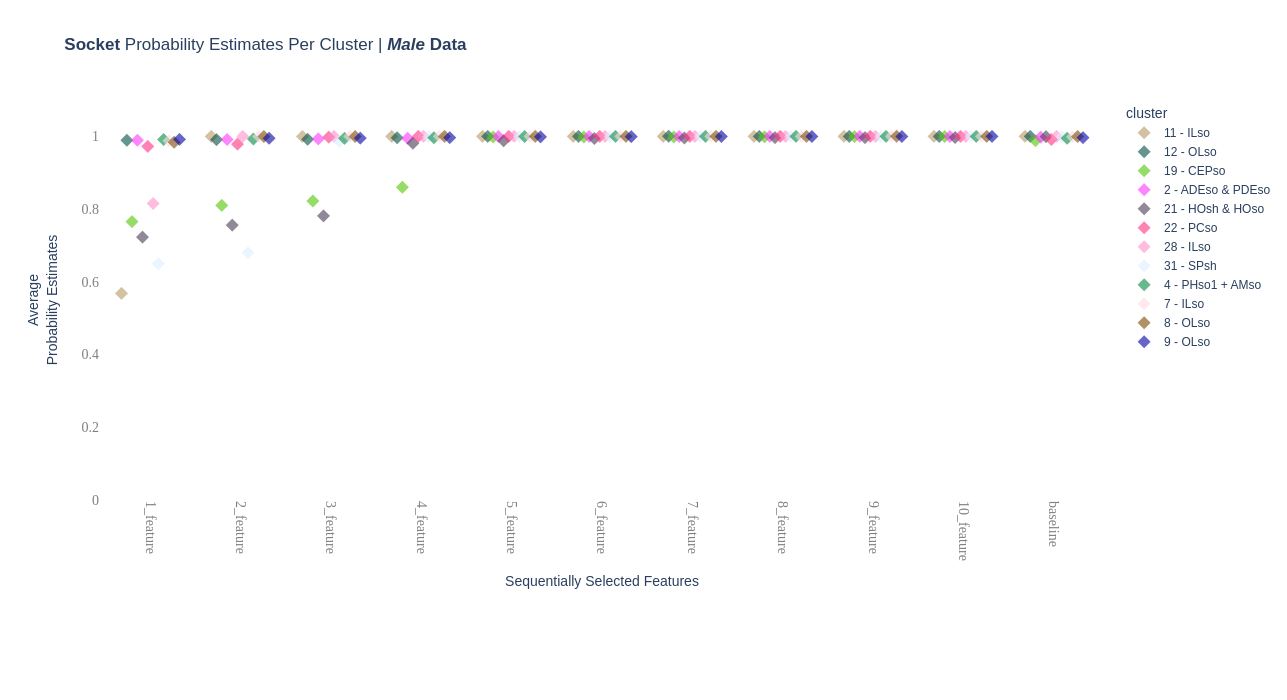

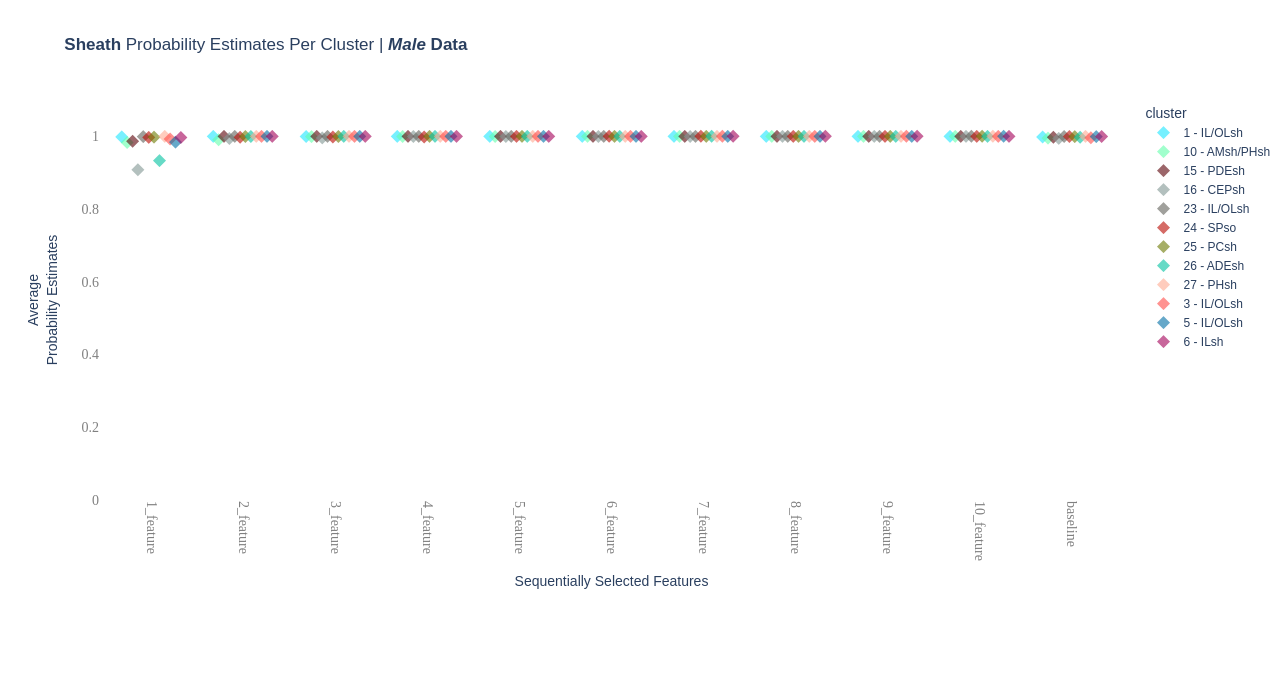

In [20]:
# male socket
view_ProbEst_Summary(
    adata_male, 
    model=model,
    target_class='Socket',
    feature_combos=socket_combinations,
    class_labels=CLASS_LABELS,
    cluster_labels=CLUSTER_LABELS,
    use_layer=USE_LAYER
)

# male sheath
view_ProbEst_Summary(
    adata_male, 
    model=model,
    target_class='Sheath',
    feature_combos=sheath_combinations,
    class_labels=CLASS_LABELS,
    cluster_labels=CLUSTER_LABELS,
    use_layer=USE_LAYER
)

### Hermaphrodite Samples

Create the Hermaphrodite dataset

In [21]:
# hermaphrodite only data -- for evaluating features selected
adata_herm = adata[
    (adata.obs['sex'] == 'Hermaphrodite') & 
    (adata.obs['sex_specificity'].isin(['Both','Herm'])),:].copy()

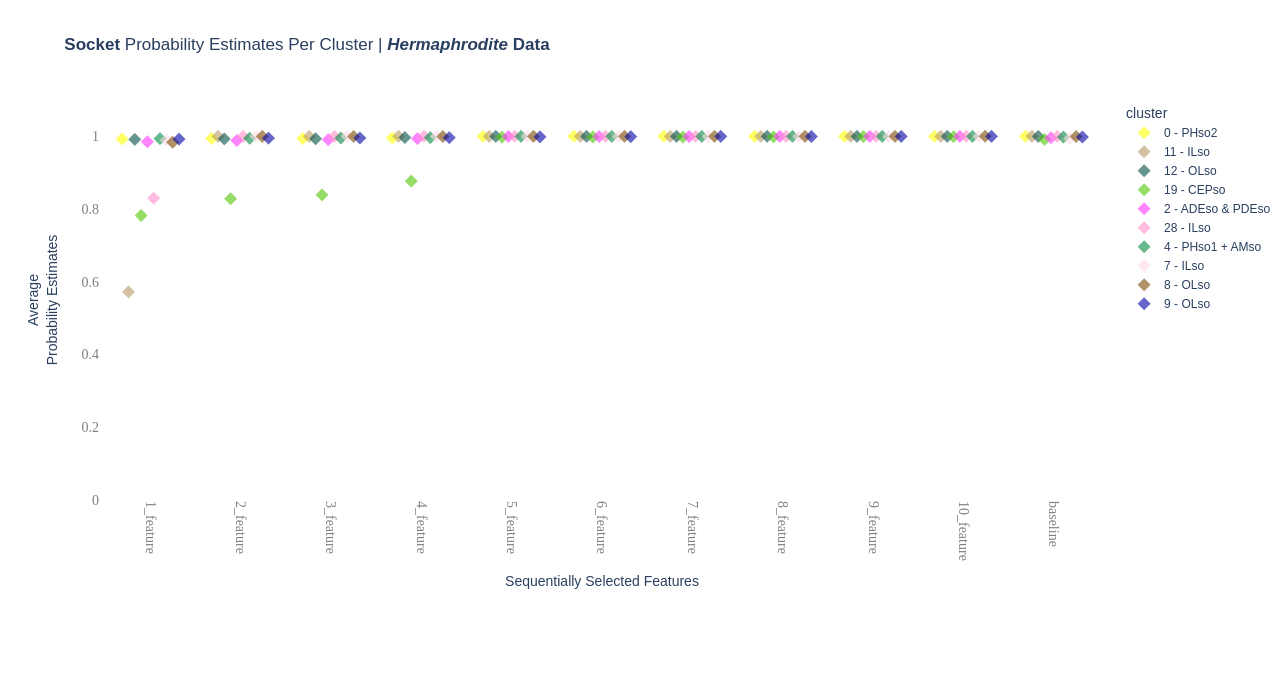

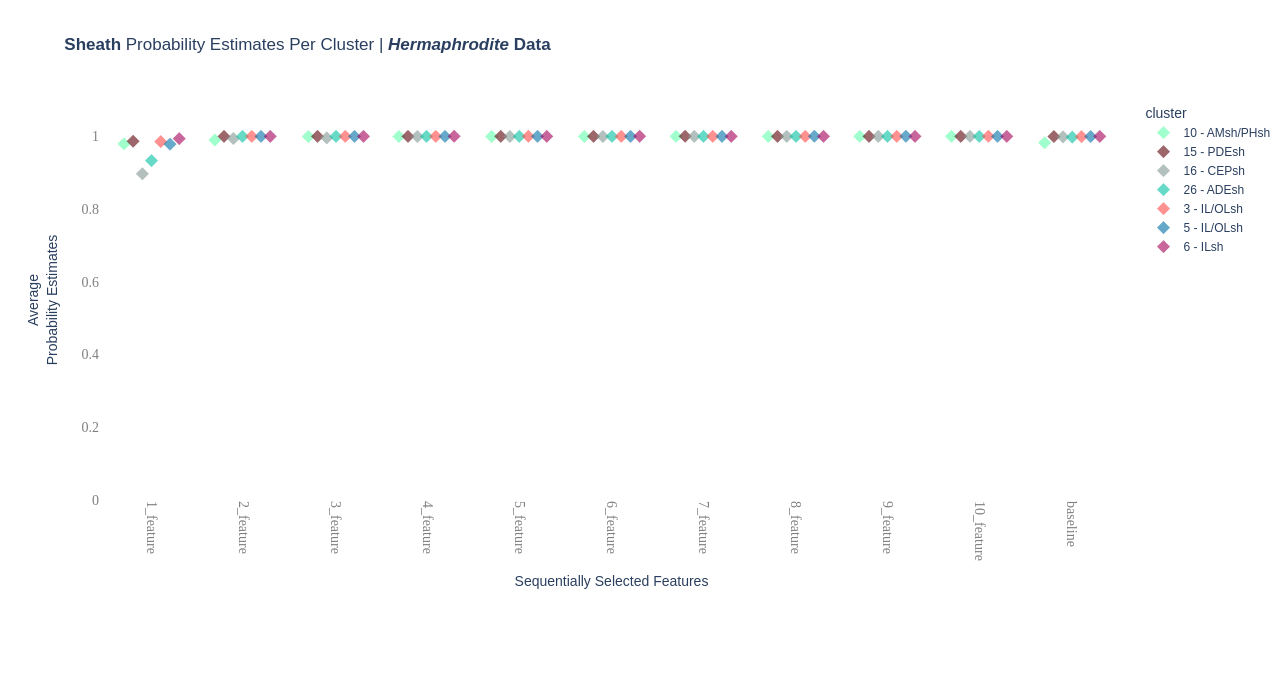

In [22]:
# herm socket
view_ProbEst_Summary(
    adata_herm, 
    model=model,
    target_class='Socket',
    feature_combos=socket_combinations,
    class_labels=CLASS_LABELS,
    cluster_labels=CLUSTER_LABELS,
    use_layer=USE_LAYER
)

# herm sheath
view_ProbEst_Summary(
    adata_herm, 
    model=model,
    target_class='Sheath',
    feature_combos=sheath_combinations,
    class_labels=CLASS_LABELS,
    cluster_labels=CLUSTER_LABELS,
    use_layer=USE_LAYER
)

# Binary Classification Performance

Using `view_AUROC_Summary()` we can evaluate and view the performance of the classifier using the set of identified genes for each of the target class on a cluster by cluster basis. The following plots below shows the AUROCC for specific clusters in a specific target class.

### Male Samples

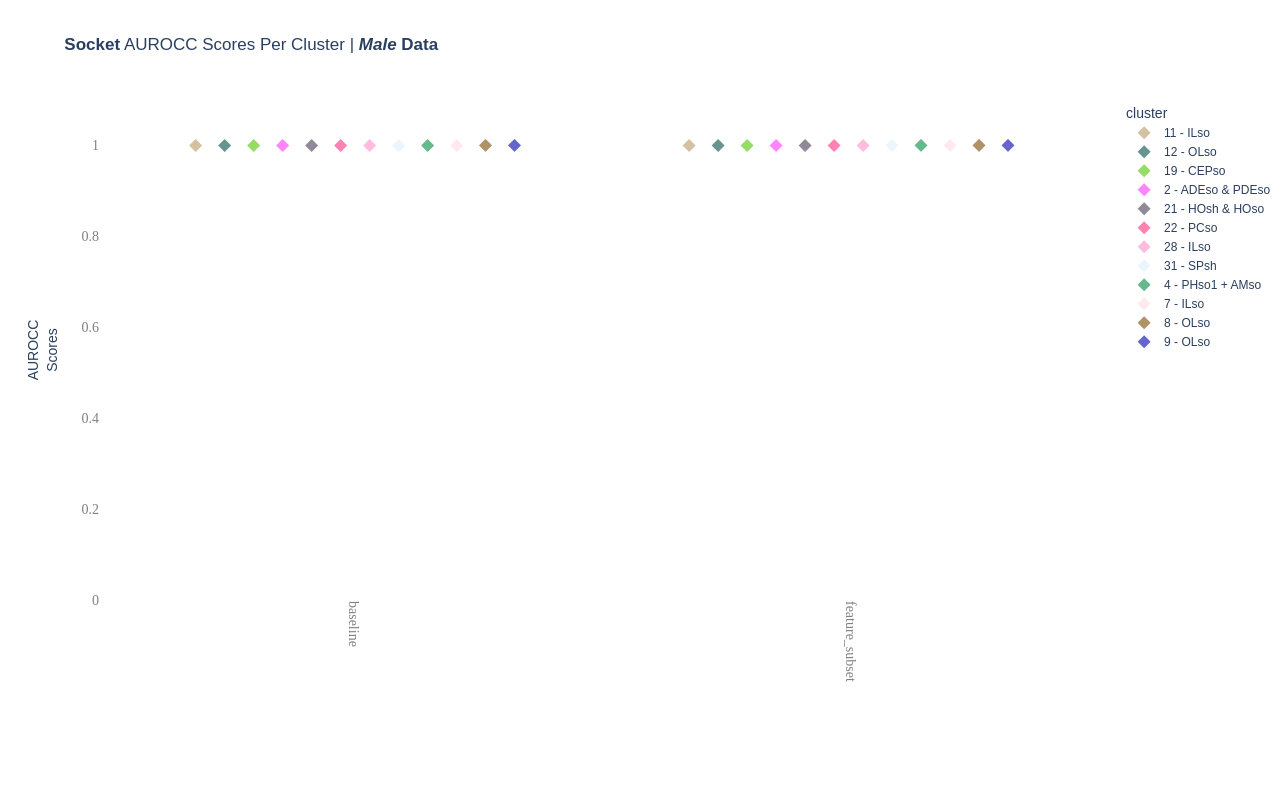

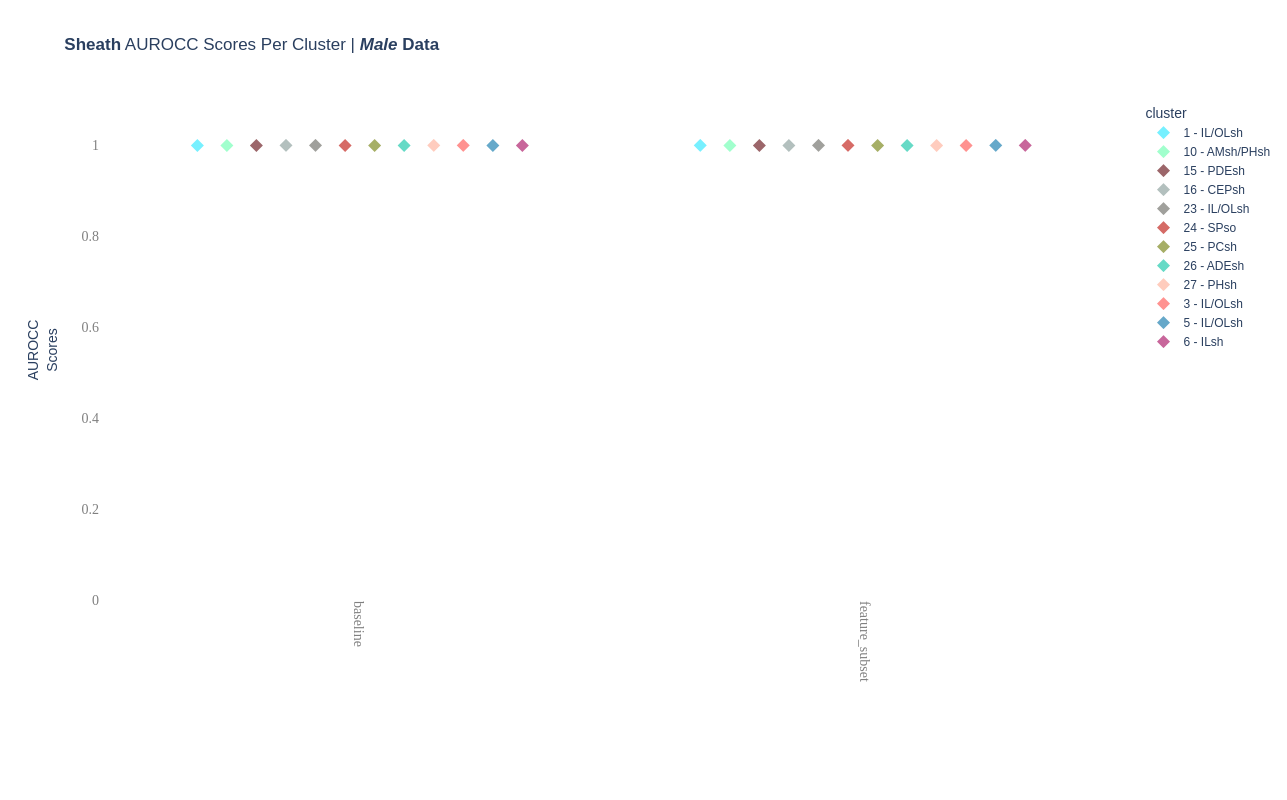

In [23]:
# males
view_AUROCC_Summary(adata_male, model=model, target_class='Socket', class_labels=CLASS_LABELS, 
                   cluster_labels=CLUSTER_LABELS, use_layer=USE_LAYER, target_features=markers)

view_AUROCC_Summary(adata_male, model=model, target_class='Sheath', class_labels=CLASS_LABELS, 
                   cluster_labels=CLUSTER_LABELS, use_layer=USE_LAYER, target_features=markers)

### Hermaphrodite Samples

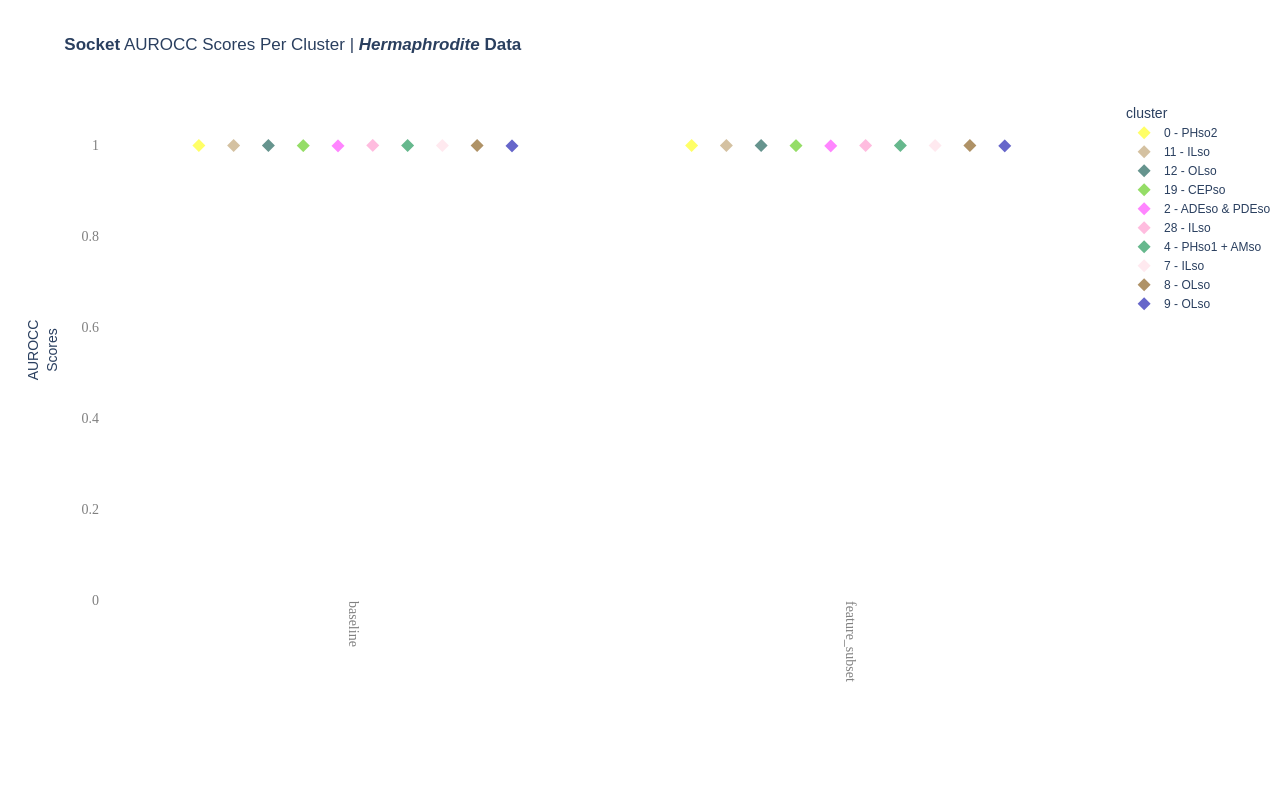

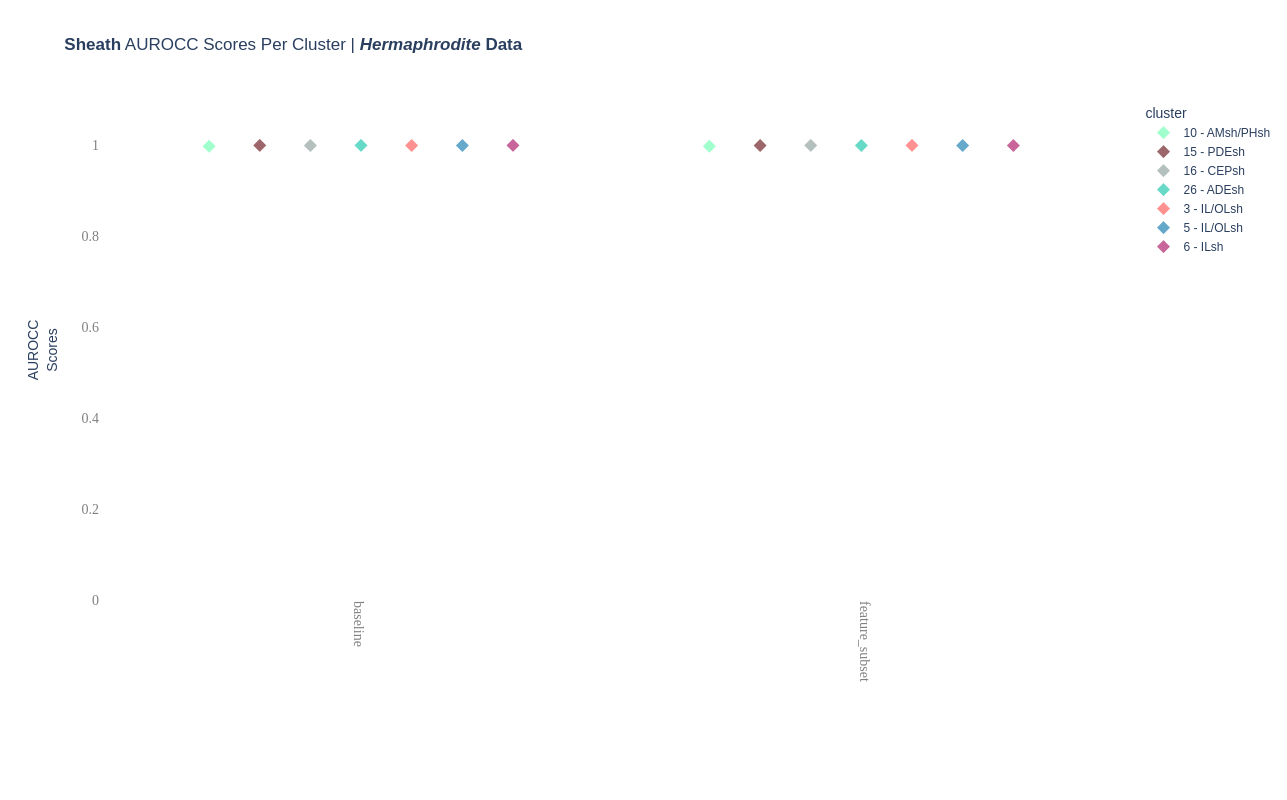

In [24]:
# hermaphrodites
view_AUROCC_Summary(adata_herm, model=model, target_class='Socket', class_labels=CLASS_LABELS, 
                   cluster_labels=CLUSTER_LABELS, use_layer=USE_LAYER, target_features=markers)

view_AUROCC_Summary(adata_herm, model=model, target_class='Sheath', class_labels=CLASS_LABELS, 
                   cluster_labels=CLUSTER_LABELS, use_layer=USE_LAYER, target_features=markers)

### Save AnnData Objects

In [25]:
# saves the male data -- used in training 
adata_male.write(f'{SAVE_PATH}/adata_male.h5ad')

# saves the hermaphrodite data
adata_herm.write(f'{SAVE_PATH}/adata_herm.h5ad')

# saves the original data with modiefied .var, .obs, .uns attributes
adata.write(f'{SAVE_PATH}/adata.h5ad')